In [1]:
## Preamble: Package Loading
import numpy as np
from sklearn import linear_model
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import itertools as iter
import os
import datetime as dt
import json
import kernel as kr
import psc_sumdisp as psd 
# Preamble working directory retreival
wkng_folder = os.getcwd()

<h2>Estimator With Only ScikitLearn Lasso</h2>

In [2]:
# dp = data_pan
# di = data_inst
# de = data_err

# dep_nm = inpt['en_nm']
# ex_nm = inpt['ex_nm']
# n_exo = inpt['n_exo']
# ins_nm = list(di.columns)[1:]
# adep_nm = [ 0 for i in range(len(dep_nm))]
# epsil = 0.05
# ain_cf = [ 0 for i in range(len(dep_nm))]
# ain_cf_rm = [ 0 for i in range(len(dep_nm))]
# excf1 = []

# for g in range(len(ex_nm)):
#     excf1 = []
#     for k in range(inpt['ncs']):
#         dsl = dp.loc[dp['crs']==k+1,['t'] + [dep_nm[g]] + ex_nm]
#         dsl = pd.merge(dsl,di,how ="inner", on='t')
#         lin_reg = linear_model.LinearRegression()
#         lin_reg.fit(dsl.loc[:,ex_nm+ins_nm].values,dsl.loc[:,dep_nm[g]].values.reshape(dsl.shape[0],1))
#         excf1.append([lin_reg.coef_[0][i] for i in range(inpt['n_exo'])])

#     incf = [0 for i in range(inpt['t_inst'])]    
#     excf = [np.mean([excf1[i][j] for i in range(len(excf1))] ) for j in range(n_exo)]

#     adep_nm[g] = ''.join(['a',dep_nm[g]])
#     dp[adep_nm[g]] = (dp.loc[:,dep_nm[g]].values.reshape(dp.shape[0],1)
#                      -dp.loc[:,ex_nm].values.dot(np.array(excf).reshape(inpt['n_exo'],1)))
    
#     ain_cf1= []
#     for k in range(inpt['ncs']):
#         ds2 = dp.loc[dp['crs']==k+1,['t'] + [adep_nm[g]] ]
#         ds2 = pd.merge(ds2,data_inst,how ="inner", on='t')
#         lasso_reg = linear_model.Lasso(alpha = 0.4)
#         lasso_reg.fit(ds2.loc[:,ins_nm].values,ds2.loc[:,adep_nm[g]].values.reshape(ds2.shape[0],1))
#         ain_cf1.append(list(lasso_reg.coef_))

#     ain_cf[g] = excf
#     for j in  range(len(ain_cf1[0])): 
#         a = [ain_cf1[i][j] for i in range(len(ain_cf1)) if np.abs(ain_cf1[i][j]) > epsil]
#         if not a:
#             ain_cf[g].append(0)
#         else:
#             ain_cf[g].append(np.mean(a))    

#     ain_cf_rm[g] = [[1,1] + [int(np.abs(ain_cf1[j][i])>epsil) 
#                             for i in range(len(ain_cf1[0]))] 
#                             for j in range(len(ain_cf1))]

In [3]:
#ain_cf

In [4]:
#pd.DataFrame(ain_cf1)

<h2> 2 Required Functions </h2>

<h3> 2.1 OLS function </h3>

In [5]:
def ols(df,inpt):
    """
INPUTS
df                (pandas df) Data Frame with all regressors
inpt              (dict) Dictionary with the following
  inpt['dep']     (string) Name of dependent variable contained in df
  inpt['reg']     (list of strings) names of regressors in df 
  inpt['cons']    (0,1) Indicator for whether a constant should be included

OUTPUTS 
out               (list of lists) List of the following
  out[0]          (list) Estimated coefficients
  out[1]          (list) Residuals
  out[2]          (list) Estimated conditional expectation
    """
    # Extracting input variables
    dep = inpt['dep']
    reg = inpt['reg']
    cons = inpt['cons']
    # Determining length of df (number of obs)
    n = df.shape[0]
    # Extracting Dependent Variable from df
    Y = df.loc[:,dep].values.reshape(n,1)
    # Extracting Regressors from df
    if len(reg) == 1:
        X = df.loc[:,reg].values.reshape(n,1)
    elif len(reg) > 1: 
        X = df.loc[:,reg].values
    # Adding column of ones if a constant is included
    if cons == 1: 
        X = np.hstack((np.ones((n,1)),X))
    # Estimated regression coefficients
    alpha = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(Y))
    # Estimated Conditional Expectation
    Yhat = X.dot(alpha)
    # Residuals of the regression
    res = Y - X.dot(alpha)
    # Constructing output list of lists
    out = [alpha.T.tolist()[0],res.T.tolist()[0],Yhat.T.tolist()[0]]
    return out

<h3> 2.2 Panel Data Estimator </h3>

This function will perform lasso estimation based on the value of inpt['lasso']

In [6]:
def panel_fe(dp_in,di_in,inpt):
    """
INPUTS
dp_in                     (pandas df) df with dependent var. and all exogenous regs
di_in                     (pandas df) df with all instruments
inpt                      (dict) Dictionary with the following
  inpt['dep']               (string) Name of dependent variable contained in dp
  inpt['reg']               (list of strings) names of exogenous regressors
  inpt['cin']               (string) name of crossection index in dp
  inpt['tin']               (string) name of time index in dp
  inpt['ncs']               (int) number of crossections
  inpt['alph']              (flt) penalty value for lasso estimation
  inpt['epsil']             (flt)  threshold for averaging "non zero" coefficients
  inpt['lasso']             (int) indicator for whether subset selection with lasso is done
  inpt['in_nm']             (list of lists of strings) with the following components
    input['in_nm'][i-1]       (list of names) names of instruments relevant to crs i 
  

OUTPUTS 
out               (list of lists) List of the following
  out[0]          (list) Estimated coefficients
  out[1]          (list) list of all relevant instrument
  out[2]          (list) Estimated error terms Vi_j
    """

    ## Extracting Variables from inpt dictionary
    dep = inpt['dep']
    reg = inpt['reg']
    in_nm = inpt['in_nm']
    cin = inpt['cin']
    tin = inpt['tin']
    ncs = inpt['ncs']
    lasso = inpt['lasso']
    di  = di_in
    dp  = dp_in

    ## Constructing a df of all instrument relevant to at least 1 crossection
    # Initializing the set of all included instruments as the 1st set relevant inst
    inc = set(in_nm[0])
    # Collecting rest of relevant instruments
    for i in range(len(in_nm)):
        # Union of inc and ith set of relevant instruments
        inc = inc|set(in_nm[i])
    # All included Instruments listed in order index order
    inc = [''.join(['W',str(i)]) for i in range(1,di.shape[1]) if ''.join(['W',str(i)]) in inc]
    # df with time index and all included instruments
    di_inc = di.loc[:,[tin] + inc]

    # List of logical vectors (as list) of which instruments in inc are relevant to ith crs
    in_vec = [[ 1 if inc[i] in in_nm[j] else 0 for i in range(len(inc))]
                  for j in range(ncs)]

    # First differenced included instrument df
    Di = di_inc.loc[:,[tin]]
    for j in range(0,len(inc)):
        # Adding D to name of jth instrument in inc
        D_nm = ''.join(['D', di_inc.columns[j+1]])
        # First difference of jth instrument in inc
        Di[D_nm] = (di_inc.loc[:,di_inc.columns[j+1]].values 
                    - di_inc.loc[:,di_inc.columns[j+1]].shift(1).values)

    ## Constructing Panel Version of relevant instrument data
    for i in range(ncs):
        # Initializing differenced panel template df
        a1 = Di.loc[:,tin].copy()
        # Adding the crossection variable
        a1 = pd.concat([a1,pd.DataFrame(np.ones((di_inc.shape[0],1))*(i+1)
                                        ,columns = [cin])],axis = 1)
        # Initializing the panel template df
        b1 = a1
        # Product of Di with in_vec[i-1] s.t. inst. not relevant to i are zero 
        a2 = pd.DataFrame(Di.iloc[:,1:].values.dot(np.diag(in_vec[i]))
                          ,columns = Di.columns[1:])
        # Product of di_inc with in_vec[i-1] s.t. inst. not relevant to i are zero
        b2 = pd.DataFrame(di_inc.iloc[:,1:].values.dot(np.diag(in_vec[i]))
                          ,columns = di_inc.columns[1:])
        # Concatenating a2 onto panel template adding [cin] and [tin]
        a2 = pd.concat([a1,a2],axis = 1)
        # Concatenating b2 onto panel template adding [cin] and [tin]
        b2 = pd.concat([b1,b2],axis = 1)
        if i == 0:
            # if  i = 0 initialize final differenced panel df
            Ddi_pan = a2.iloc[1:,:]
            # if i = 0 initialize final panel df
            di_pan = b2
        elif i > 0: 
            # if i > 0 add ith crosssection rows onto final
            Ddi_pan = pd.concat([Ddi_pan,a2.iloc[1:,:]], axis = 0)
            # if i > 0 add ith crosssection rows onto final
            di_pan =  pd.concat([di_pan,b2], axis = 0)

    ## First Difference dependent and exogenous regressor matrix..
    for i in range(1,ncs+1):
        # Initializing panle template df
        c1 = dp.loc[dp[cin]== i,[cin]+[tin]].copy() 
        # First differencing al relevant variables for i crs
        for j in [inpt['dep']] + inpt['reg']:
            c1[''.join(['D',j])] = (dp.loc[dp[cin]== i,j].values 
                        - dp.loc[dp[cin]== i,j].shift(1).values)
        if i == 1:
            # If i = 1 initialize final panel df
            c2 = c1.iloc[1:,:]  
        elif i > 1:
            # If i > 1 add onto final panel df
            c2 = pd.concat([c2,c1.iloc[1:,:]],axis = 0)

    ## OLS estimation
    # Merging all differenced panel df's together
    Ddi_pan = pd.merge(c2,Ddi_pan,on=[cin,tin],how = 'inner')
    # List of all regressor names in Ddi_pan for use in ols()
    Dregs = ([''.join(['D',reg[i]]) for i in range(len(reg))] 
            + [''.join(['D',inc[i]]) for i in range(len(inc))])
    # Dictionary for input into ols()
    inpt_ols = {'dep': ''.join(['D',dep]) , 'reg': Dregs, 'cons': 0}
    ## Lasso Estimation
    l_inpt = {'dep': ''.join(['D',dep]),
                  'ex_nm': [''.join(['D',reg[i]]) for i in range(len(reg))],
                  'ins_nm': [''.join(['D',inc[i]]) for i in range(len(inc))],
                  'alph': inpt['alph'],
                  'ncs':inpt['ncs'],
                  'epsil':inpt['epsil']
                 }
    # Names of all exogenous regressor and inst. included in di_pan
    regs = ([ reg[i] for i in range(len(reg))] 
            + [ inc[i] for i in range(len(inc))])

    # Constucting a panel df of esitmated errors Vj,i
    for i in range(1,ncs+1):
        # np.array of dep variable values for ith crs
        d1 = dp.loc[dp[cin] == i,[dep]].values
        # df of exogenous regressor values for ith crs
        d21 = dp.loc[dp[cin] == i ,[cin]+[tin]+reg]
        # included instruments panel with indexes for i 
        d22 = di_pan.loc[di_pan[cin] == i,[cin]+[tin]+inc]
        # merging d21 and d22 making a df with all RHS regressors 
        d23 = pd.merge(d21,d22,on = [cin,tin], how = 'inner')
        if lasso==1:
            # Estimation by panel lasso
            out = pan_lasso(Ddi_pan,l_inpt)
            # Extracting estimated coefficients
            e_cf = np.array(out[0]).reshape(len(out[0]),1)
            # Zeroing out columns which we not selected by the lasso
            d23_1 = d23.drop([cin,tin],axis=1).values.dot(np.diag(out[1][0]))
            # Generating fitted values
            d2 = d23_1.dot(e_cf)
        elif lasso==0:
            # Estimation by ols()
            ols_out = ols(Ddi_pan,inpt_ols)
            # Estimated coefficient from estimator above 
            e_cf = np.array(ols_out[0]).reshape(len(ols_out[0]),1)
            # Estimated time varying component of dependent variable
            d2 = d23.drop([cin,tin],axis = 1).values.dot(e_cf)
        # Residual of time varying component 
        d3 = d1.reshape(d1.shape[0],1) - d2
        # Centered residula of time varying component
        d3 = d3 - np.mean(d3)
        if i == 1:
            # if i = 1 initialize panel df
            p_res = [list(d3.T[0])]
        elif i > 1:
            # if i > 1 add onto p_res
            p_res.append(list(d3.T[0]))

    # Output of the function
    out = [list(e_cf.T[0]), inc , p_res ]
    return out

<h3> 2.4 Lasso Panel Estimator </h3>

In [7]:
def pan_lasso(l_dp,l_inpt):
    """
INPUTS
l_dp                 dataframe of all panel regression variables 
l_inpt               dictionary with the following elements
  l_inpt['dep']        (str) name of dependent variable
  l_inpt['ex_nm']      (str) name of all exogenous variables
  l_inpt['ins_nm']     (str) name of all instruments
  l_inpt['alph']       (flt) lasso penalty parameter
  l_inpt['ncs']        (int) number of cross sections
  l_inpt['epsil']      (flt) threshold for averaging "non zero" coefficients
  
OUTPUTS
out            (list) with the following elements
 out[0]        (list) Estimated coefficients
 out[1]        (list) containing the following elements
   out[1][j]   (list) binary vector indicating the non zero ceofficients for each crs
    """
    l_dep_nm = l_inpt['dep']
    l_ex_nm = l_inpt['ex_nm']
    l_ins_nm = l_inpt['ins_nm']
    l_alph = l_inpt['alph']
    l_epsil = l_inpt['epsil']
    n_exo = len(l_ex_nm)
    ncs = l_inpt['ncs']
    t_inst = len(l_ins_nm)
    excf1 = []

    for k in range(inpt['ncs']):
        dsl = l_dp.loc[l_dp['crs']==k+1,:]
        lin_reg = linear_model.LinearRegression()
        lin_reg.fit(dsl.loc[:,l_ex_nm+l_ins_nm].values,
                    dsl.loc[:,l_dep_nm].values.reshape(dsl.shape[0],1))
        excf1.append([lin_reg.coef_[0][i] for i in range(n_exo)])

    incf = [0 for i in range(t_inst)]    
    excf = [np.mean([excf1[i][j] for i in range(len(excf1))]) for j in range(n_exo)]

    adep_nm = ''.join(['a',l_dep_nm])
    l_dp[adep_nm] = (l_dp.loc[:,l_dep_nm].values.reshape(l_dp.shape[0],1)
                     -l_dp.loc[:,l_ex_nm].values.dot(np.array(excf).reshape(n_exo,1)))

    ain_cf1= []
    for k in range(ncs):
        ds2 = l_dp.loc[l_dp['crs']==k+1,:]
        lasso_reg = linear_model.Lasso(alpha = 0.4)
        lasso_reg.fit(ds2.loc[:,l_ins_nm].values,
                      ds2.loc[:,adep_nm].values.reshape(ds2.shape[0],1))
        ain_cf1.append(list(lasso_reg.coef_))

    ain_cf = excf
    for j in range(len(ain_cf1[0])): 
        a = [ain_cf1[i][j] for i in range(len(ain_cf1)) if np.abs(ain_cf1[i][j]) > l_epsil]
        if not a:
            ain_cf.append(0)
        else:
            ain_cf.append(np.mean(a))    

    ain_cf_rm = [[1,1] + [int(np.abs(ain_cf1[j][i])>l_epsil) 
                            for i in range(len(ain_cf1[0]))] 
                           for j in range(len(ain_cf1))]
    out = [ain_cf, ain_cf_rm]
    return out

<h2> 3 Setup and Functions Call </h2>

<h3> 3.1 Data Loading </h3>

In [8]:
input_filename = 'pscdata_6_13_1280.json'
data_file = '/Users/ericpenner/Google_Drive/Research/pan_sel_cntrl/data'
input_file_full = ''.join([data_file,'/',input_filename])
with open(input_file_full) as f_obj: 
    pscdata = json.load(f_obj)
inpt = pscdata[0][0].copy()    

<h3> 3.2 Input Dictionary Setup </h3>

In [9]:
# Indicator for  whether in this run the subset of instrument relvant to each crs is known.
inpt['kwnsub'] = 0 

# Indicator for whether residuals are observed
inpt['orcl'] = 0
inpt['lasso'] = 0
inpt['dep'] = inpt['en_nm'][0]
inpt['reg'] = inpt['ex_nm']
inpt['alph'] = 0.4
inpt['epsil'] = 0.05
# List of list with the names of the relevant instruments for each crossection
in_nm=[]
for i in range(inpt['ncs']):
    # If the subset is known then list of relevant inst. for each crs is supplied to estimator
    if inpt['kwnsub'] == 1:
        a=[ True if pscdata[0][1]['coeff'][0][i][k]!=0 else False 
            for k in range(inpt['n_exo'],inpt['n_exo']+inpt['t_inst'])]
        in_nm.append(np.array(pscdata[0][1]['Dins_nms'][1:])[a].tolist())
    # If the subset is unknown then list of all inst. will be supplied to est. for each crs
    else:
        in_nm.append(pscdata[0][1]['Dins_nms'][1:])
inpt['in_nm'] = in_nm

<h3> 3.3 Data Set Extraction and Function Call </h3>

In [10]:
k=10
data_err = pd.DataFrame(pscdata[k][0]['err_df'], columns = pscdata[0][1]['Derr_nms'])  
data_inst = pd.DataFrame(pscdata[k][0]['inst_df'], columns = pscdata[0][1]['Dins_nms'])
data_pan = pd.DataFrame(pscdata[k][0]['prim_df'], columns = pscdata[0][1]['Dlng_nms'])
c = panel_fe(data_pan,data_inst,inpt)


In [11]:
#pd.DataFrame(pscdata[0][1]['coeff'][1])

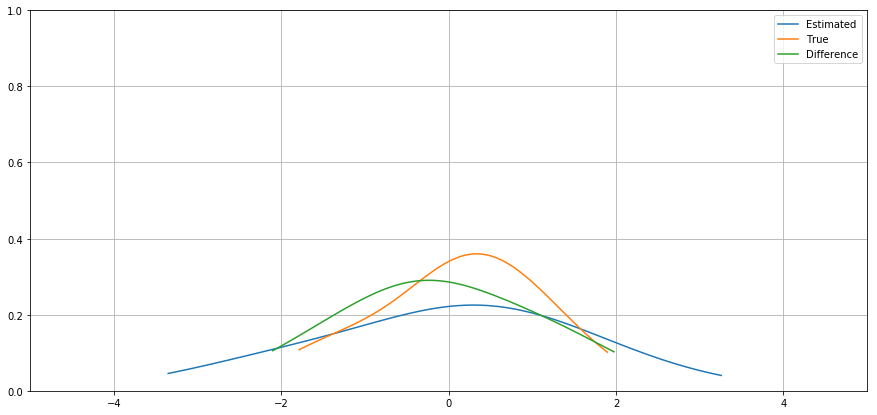

In [12]:
i=8
h_c = 1.5
ker = 9

V_est = np.array(c[2][i-1])
p_est = np.linspace(np.min(V_est),np.max(V_est),100)
h_est = h_c*V_est.shape[0]**(-1/5)*np.std(V_est)
V_est_den = kr.mvden(V_est,p_est,h_est,ker)

V_true = data_err.loc[data_err['crs']==i,'V1'].values
p_true = np.linspace(np.min(V_true),np.max(V_true),100)
h_true = h_c*V_true.shape[0]**(-1/5)*np.std(V_true)
V_true_den = kr.mvden(V_true,p_true,h_true,ker) 

V_diff = V_est - V_true
p_diff = np.linspace(np.min(V_diff),np.max(V_diff),100)
h_diff = h_c*V_diff.shape[0]**(-1/5)*np.std(V_diff)
V_diff_den = kr.mvden(V_diff,p_diff,h_diff,ker) 


x_lm = [-5,5]
y_lm = 1

f,ax = plt.subplots()
f.set_figheight(7)
f.set_figwidth(15)
ax.set_xlim((x_lm[0],x_lm[1]))
ax.set_ylim((0,y_lm))
ax.plot(p_est,V_est_den)
ax.plot(p_true,V_true_den)
ax.plot(p_diff,V_diff_den)
ax.legend(["Estimated","True","Difference"])
ax.grid(which = 'both')
#ax.set_title(''.join(['Distribution of Estimated ',coeff[0].columns[w]]))
plt.show()